In [108]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [109]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [112]:
import torch
import torch.nn as nn

In [113]:
#Loading the Amazon Minute data
df = pd.read_csv('/kaggle/input/amzn-1mintxt/AMZN_1min.txt')
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

total_rows = len(df)
rows_to_keep = int(0.10 * total_rows)

# Keep only the last 10% of the data
df= df[-rows_to_keep:]
df

,timestamp,open,high,low,close,volume
1801572,2020-06-25 15:50:00,2751.670,2752.62,2750.55,2751.130,18088
1801573,2020-06-25 15:51:00,2750.740,2752.68,2750.74,2752.360,10633
1801574,2020-06-25 15:52:00,2752.157,2752.55,2751.00,2751.625,8481
1801575,2020-06-25 15:53:00,2751.505,2752.44,2750.80,2750.800,10762
1801576,2020-06-25 15:54:00,2751.135,2755.45,2749.83,2755.450,27677
...,...,...,...,...,...,...
2001741,2022-02-25 17:55:00,3074.700,3074.70,3074.70,3074.700,100
2001742,2022-02-25 18:13:00,3074.000,3074.00,3074.00,3074.000,100
2001743,2022-02-25 18:46:00,3075.000,3075.00,3075.00,3075.000,100
2001744,2022-02-25 19:08:00,3077.500,3077.50,3077.50,3077.500,152


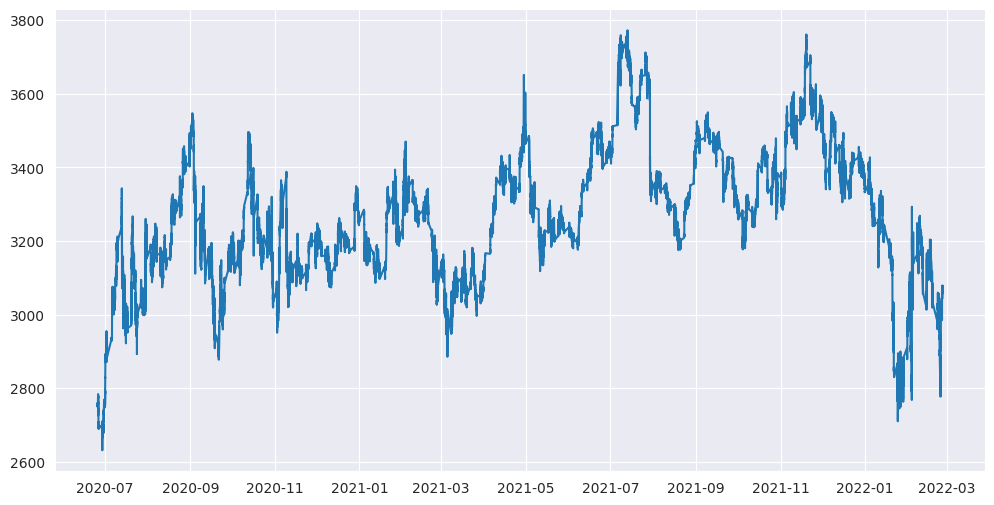

In [114]:
# Plot the close price as a function of timestamp
plt.figure(figsize=(12, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

plt.plot(df['timestamp'], df['close'])

In [115]:
price = df[['close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200174 entries, 1801572 to 2001745
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   200174 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [116]:
#Print the close price column
price['close']

1801572    2751.130
1801573    2752.360
1801574    2751.625
1801575    2750.800
1801576    2755.450
             ...   
2001741    3074.700
2001742    3074.000
2001743    3075.000
2001744    3077.500
2001745    3075.000
Name: close, Length: 200174, dtype: float64

In [180]:
#Normalizing with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

price1 = df[['close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price1['close'] = scaler.fit_transform(price1['close'].values.reshape(-1,1))

#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

/tmp/ipykernel_29/2827224356.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [181]:
price1['close']

1801572   -0.790105
1801573   -0.787949
1801574   -0.789237
1801575   -0.790684
1801576   -0.782532
             ...   
2001741   -0.222889
2001742   -0.224116
2001743   -0.222363
2001744   -0.217980
2001745   -0.222363
Name: close, Length: 200174, dtype: float64

In [117]:
#Normalizing with QuantileTransformer
from sklearn.preprocessing import QuantileTransformer

# Instantiate the QuantileTransformer with desired parameters
scaler = QuantileTransformer(output_distribution='uniform')

# Fit and transform the 'close' prices using the QuantileTransformer
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))

#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

/tmp/ipykernel_29/1475305990.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



I have considered two Normalizer **MinMaxScaker** and **QuantileTransformer**. I have Used The **QuantileTransformer**  because i got better result with QuantileTransformer as it a was found it is good with time series data

In [118]:
price['close']

1801572    0.006119
1801573    0.006305
1801574    0.006193
1801575    0.006069
1801576    0.006772
             ...   
2001741    0.137785
2001742    0.137137
2001743    0.138062
2001744    0.140308
2001745    0.138062
Name: close, Length: 200174, dtype: float64

I have considered the **Minute** data or **Intraday Trading**

In [119]:
#Spliting the data for the supervised case of predicting the time series with given
# 15 column data to predict the 16th column value
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [120]:
# choose sequence length 
lookback = 20 

#calling the Split_data function 
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (160123, 19, 1)
y_train.shape =  (160123, 1)
x_test.shape =  (40031, 19, 1)
y_test.shape =  (40031, 1)


In [121]:
#import pytorch and Neural Network Architecture from Pytorch
import torch
import torch.nn as nn

#Converting the dataframe into the torch tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

#https://saturncloud.io/blog/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor/

In [122]:
y_train_lstm

tensor([[0.0063],
        [0.0062],
        [0.0062],
        ...,
        [0.7056],
        [0.7033],
        [0.7064]])

In [123]:
#Configue parameters to train
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [124]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [125]:
#Initializing the model architecture and i have used MSE loss and Adam Optimiser 
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)



In [126]:
#Training the model 
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4215924143791199
Epoch  1 MSE:  0.22801531851291656
Epoch  2 MSE:  0.07636840641498566
Epoch  3 MSE:  0.2198256552219391
Epoch  4 MSE:  0.09295235574245453
Epoch  5 MSE:  0.06274458765983582
Epoch  6 MSE:  0.08214592188596725
Epoch  7 MSE:  0.09821219742298126
Epoch  8 MSE:  0.10175295174121857
Epoch  9 MSE:  0.09535118192434311
Epoch  10 MSE:  0.08343382924795151
Epoch  11 MSE:  0.07046998292207718
Epoch  12 MSE:  0.06064625456929207
Epoch  13 MSE:  0.05713018402457237
Epoch  14 MSE:  0.06027587875723839
Epoch  15 MSE:  0.06583709269762039
Epoch  16 MSE:  0.06724574416875839
Epoch  17 MSE:  0.062074773013591766
Epoch  18 MSE:  0.053592417389154434
Epoch  19 MSE:  0.04611450061202049
Epoch  20 MSE:  0.04146561026573181
Epoch  21 MSE:  0.038805533200502396
Epoch  22 MSE:  0.0357619971036911
Epoch  23 MSE:  0.029444722458720207
Epoch  24 MSE:  0.017888551577925682
Epoch  25 MSE:  0.007245377637445927
Epoch  26 MSE:  0.016081979498267174
Epoch  27 MSE:  0.0093811629340052

In [127]:
#forming a dataframe which has inverse tranformed close price of actual and the trained values
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

In [128]:
pip install seaborn
#https://seaborn.pydata.org/

Note: you may need to restart the kernel to use updated packages.


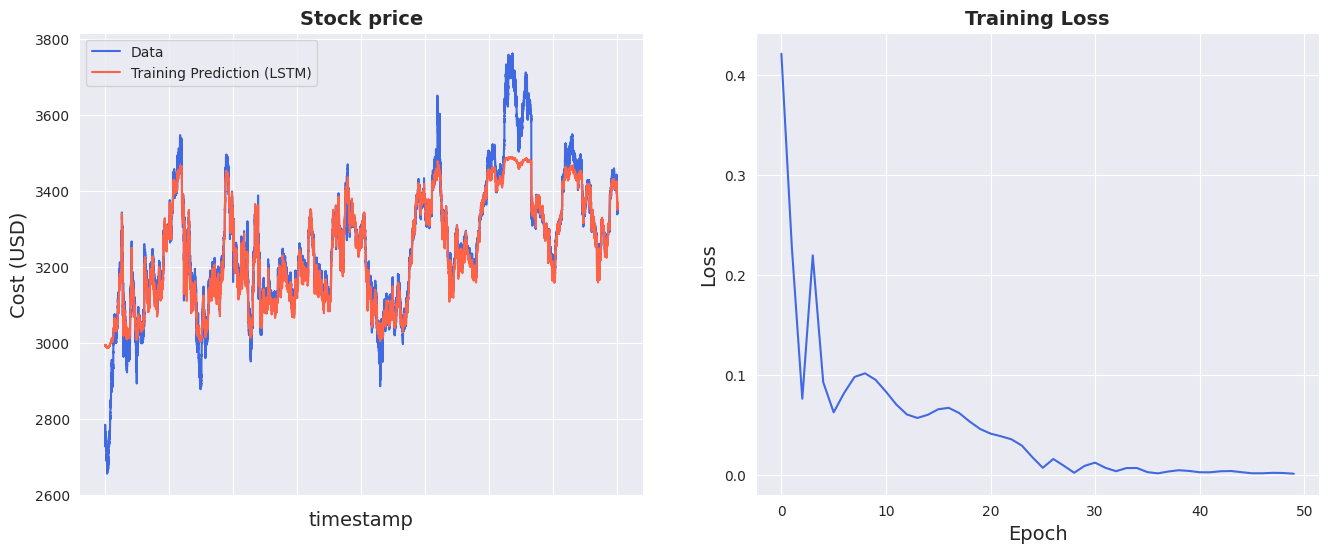

In [179]:
#PLotting the Train prediction and Actual Train data along with the training loss vs no of epochs
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#Stock Price vs timestamp
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("timestamp", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

#Training loss vs epochs
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

In [130]:
#Calculting the RMSE for Train and Test datset 
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

Train Score: 53.15 RMSE
Test Score: 67.51 RMSE


In [131]:
y_train_lstm

tensor([[0.0063],
        [0.0062],
        [0.0062],
        ...,
        [0.7056],
        [0.7033],
        [0.7064]])

In [132]:
y_train

array([[2752.    ],
       [2751.55  ],
       [2751.77  ],
       ...,
       [3352.9507],
       [3351.985 ],
       [3353.32  ]], dtype=float32)

In [144]:
y_test

array([[3354.99 ],
       [3356.365],
       [3355.07 ],
       ...,
       [3074.   ],
       [3075.   ],
       [3077.5  ]], dtype=float32)

In [141]:
y_test_pred

array([[3383.3374],
       [3383.1213],
       [3383.0618],
       ...,
       [3065.9033],
       [3065.8303],
       [3065.8357]], dtype=float32)

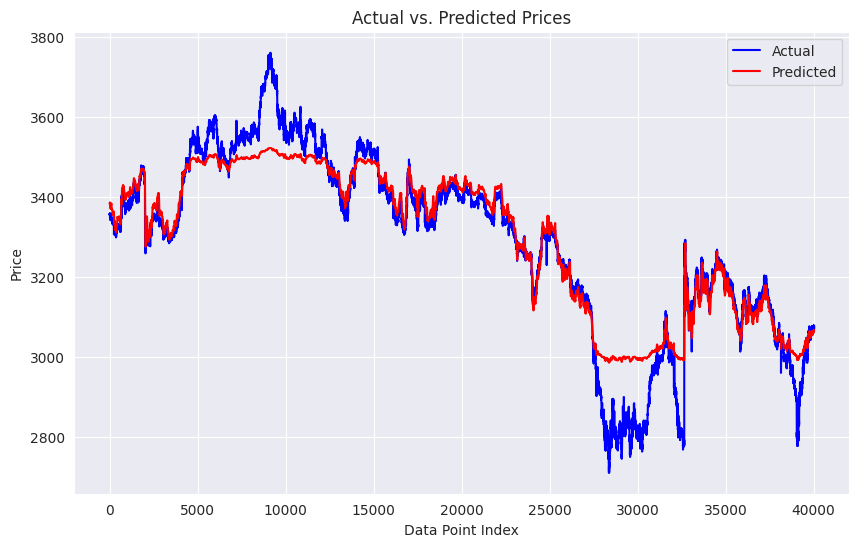

In [135]:
#Plotting the Predicted abd actual Close price values
x = np.arange(len(y_test))

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the actual values (y_test) in blue
plt.plot(x, y_test, label='Actual', color='blue')

# Plot the predicted values (y_test_pred) in orange
plt.plot(x, y_test_pred, label='Predicted', color='red')

# Set axis labels and legend
plt.xlabel('Data Point Index')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Prices')
plt.show()


**Q8**
a) As we can see as the price prediction error increase as we go further from the last time on which it was trained becuase a stock does not follows a particular trend and the loss keeps on increasing

In [166]:
y_test

array([[3354.99 ],
       [3356.365],
       [3355.07 ],
       ...,
       [3074.   ],
       [3075.   ],
       [3077.5  ]], dtype=float32)

In [178]:
#Building the Trading strategy
def trading_strategy(predicted_prices, actual_prices, initial_balance=10000):
    balance = initial_balance
    shares = 0
    orders = []
    buy_trades = 0
    sell_trades = 0

    for i in range(len(predicted_prices) - 1):  # Adjust the loop range to avoid index out of bounds
        predicted_price_next = predicted_prices[i + 1]
        actual_price = actual_prices[i]

        # Convert to regular Python floats
        predicted_price_next = float(predicted_price_next)
        actual_price = float(actual_price)

        # Buy if predicted price for the next minute is greater than the current actual price
        if predicted_price_next > actual_price:
            # Buy
            if balance >= actual_price:
                shares_to_buy = int(balance // actual_price)
                shares += shares_to_buy
                balance -= shares_to_buy * actual_price
                orders.append(f"Buy {shares_to_buy} shares at ${actual_price:.2f}")
                buy_trades += 1
        
        # Sell if predicted price for the next minute is less than the current actual price
        elif predicted_price_next < actual_price:
            # Sell
            if shares > 0:
                balance += shares * actual_price
                orders.append(f"Sell {shares} shares at ${actual_price:.2f}")
                sell_trades += 1
                shares = 0

    # Calculate final returns
    if shares > 0:
        final_balance = balance + (shares * actual_prices[-1])
    else:
        final_balance = balance
    returns = float((final_balance - initial_balance) / initial_balance * 100)

    # Print trading orders and returns
    print("Trading Orders:")
    for order in orders:
        print(order)
    print(f"Initial Balance: ${initial_balance:.2f}")
    print(f"Final Balance: ${float(final_balance):.2f}")  # Convert final_balance to float
    print(f"Returns: {returns:.2f}%")
    print(f"Number of Buy Trades: {buy_trades}")
    print(f"Number of Sell Trades: {sell_trades}")

# Call the trading function with your predicted and actual prices
trading_strategy(y_test, y_test_pred)


#https://github.com/maroofsyyed/Oanda-Utils/tree/main/oandaUtils

Trading Orders:
Buy 2 shares at $3352.39
Sell 2 shares at $3373.94
Buy 2 shares at $3385.76
Sell 2 shares at $3400.26
Buy 2 shares at $3455.62
Sell 2 shares at $3456.02
Buy 2 shares at $3456.64
Sell 2 shares at $3457.30
Buy 2 shares at $3459.59
Sell 2 shares at $3471.06
Buy 2 shares at $3471.06
Sell 2 shares at $3468.97
Buy 2 shares at $3468.91
Sell 2 shares at $3468.45
Buy 2 shares at $3465.40
Sell 2 shares at $3470.38
Buy 2 shares at $3469.21
Sell 2 shares at $3468.77
Buy 2 shares at $3468.60
Sell 2 shares at $3468.43
Buy 2 shares at $3468.36
Sell 2 shares at $3468.28
Buy 2 shares at $3468.22
Sell 2 shares at $3469.31
Buy 2 shares at $3468.90
Sell 2 shares at $3468.40
Buy 2 shares at $3461.37
Sell 2 shares at $3461.54
Buy 3 shares at $3276.11
Sell 3 shares at $3313.33
Buy 3 shares at $3318.16
Sell 3 shares at $3318.70
Buy 3 shares at $3333.47
Sell 3 shares at $3335.44
Buy 3 shares at $3288.38
Sell 3 shares at $3293.44
Buy 3 shares at $3297.67
Sell 3 shares at $3298.07
Buy 3 shares at

If we consider the Trade commission of trade we should calculate the 0.05% of the trading volume as the cost 
which is
*transaction_cost = shares_to_buy * actual_price * trade_commission*

In above stratgey the Trade commssion is 0.0005*(381 + 382)*2*3050 = 2372.15
Hence total Returns = 15488.38 - 2372.15 = 13116.23
Which is **31.16% Returns**


**Q8**
b)As we can see I can trade with a profit of **31%** return which is really good

c)where as if we hold the stock then we will suffer a loss of **-8%**